In [1]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px

In [2]:
df_supply_chain = pd.read_csv('aircraft_supply_chain_data.csv')

In [3]:
df_supply_chain['Time to Deliver (Days)'] = df_supply_chain['Time to Deliver (Hours)'] / 24

fig_delivery = px.scatter(
    df_supply_chain, 
    x='Cost per Part (USD)', 
    y='Time to Deliver (Days)',  
    size='Quantity in Stock', 
    color='Supplier', 
    hover_name='Part Number',
    title=f'Delivery Time vs Cost per Part (USD)'
)



In [4]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Aircraft Spare Parts Supply Chain Dashboard"),

    dcc.Dropdown(
        id='airline-dropdown',
        options=[{'label': airline, 'value': airline} for airline in df_supply_chain['Airline'].unique()],
        value=df_supply_chain['Airline'].iloc[0]
    ),

    dcc.Graph(id='stock-availability-graph'),

    dcc.Graph(id='delivery-time-cost-graph')
])

@app.callback(
    [dash.dependencies.Output('stock-availability-graph', 'figure'),
     dash.dependencies.Output('delivery-time-cost-graph', 'figure')],
    [dash.dependencies.Input('airline-dropdown', 'value')]
)
def update_graphs(airline):

    airline_data = df_supply_chain[df_supply_chain['Airline'] == airline]

    fig_stock = px.bar(airline_data, x='Part Number', y='Quantity in Stock', color='Supplier',
                       title=f'Spare Part Stock Availability for {airline}')

    fig_delivery = px.scatter(airline_data, x='Cost per Part (USD)', y='Time to Deliver (Days)',
                              size='Quantity in Stock', color='Supplier', hover_name='Part Number',
                              title=f'Delivery Time vs Cost for {airline}')

    return fig_stock, fig_delivery
if __name__ == '__main__':
    app.run_server(debug=True, port=8060)
    

In [5]:
import random
import time

def update_real_time_data(df):
   
    df['Quantity in Stock'] = df['Quantity in Stock'].apply(lambda x: max(0, x - random.randint(0, 2)))
    
    df['Time to Deliver (Days)'] = df['Time to Deliver (Days)'].apply(lambda x: max(1, x + random.randint(-2, 3)))
 
    df['Cost per Part (USD)'] = df['Cost per Part (USD)'].apply(lambda x: max(500, x + random.randint(-500, 1000)))

    return df

In [6]:

for _ in range(5):  
    df_supply_chain = update_real_time_data(df_supply_chain)
    
   
    df_supply_chain.to_csv('aircraft_supply_chain_data_real_time.csv', index=False)
    
    time.sleep(5)
    
    print(df_supply_chain.head())

  Part Number    Part Description                 Supplier        Country  \
0  0002-AC108    Engine 1 Turbine          Lockheed Martin  United States   
1      ER-222  Landing Gear Front              BAE Systems  United States   
2     BZ-9876       Fuel Injector  Leonardo (Finmeccanica)  United States   
3     AC-5678      Wing Flap Left                   Airbus  United States   
4     DL-2309   Navigation System          Lockheed Martin  United States   

   Quantity in Stock  Cost per Part (USD)  Time to Deliver (Hours)  \
0                 16                25659                       35   
1                 49                17514                        6   
2                  0                 8181                        3   
3                 42                53385                       24   
4                  6                31041                       33   

  Calibration Status   Aircraft Type             Airline Aircraft Number  \
0          Unchecked      Boeing 737    

In [7]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px
from dash.dependencies import Input, Output

In [8]:
app = dash.Dash(__name__)

df_supply_chain = pd.read_csv('aircraft_supply_chain_data_real_time.csv')
df_supply_chain['Time to Deliver (Days)'] = df_supply_chain['Time to Deliver (Hours)'] / 24

fig_delivery = px.scatter(
    df_supply_chain, 
    x='Cost per Part (USD)', 
    y='Time to Deliver (Days)',  
    size='Quantity in Stock', 
    color='Supplier', 
    hover_name='Part Number',
    title=f'Delivery Time vs Cost per Part (USD)'
)

In [9]:
app.layout = html.Div([
    html.H1("Aircraft Spare Parts Supply Chain Dashboard - Real-Time"),

    dcc.Dropdown(
        id='airline-dropdown',
        options=[{'label': airline, 'value': airline} for airline in df_supply_chain['Airline'].unique()],
        value=df_supply_chain['Airline'].iloc[0]
    ),

    dcc.Graph(id='stock-availability-graph'),

    dcc.Interval(
        id='interval-component',
        interval=5*1000,  
        n_intervals=0
    )
])

@app.callback(
    Output('stock-availability-graph', 'figure'),
    [Input('airline-dropdown', 'value'), Input('interval-component', 'n_intervals')]
)
def update_graph(airline, n):
    
    df_supply_chain = pd.read_csv('aircraft_supply_chain_data_real_time.csv')
    
    airline_data = df_supply_chain[df_supply_chain['Airline'] == airline]

    fig_stock = px.bar(airline_data, x='Part Number', y='Quantity in Stock', color='Supplier',
                       title=f'Real-Time Spare Part Stock Availability for {airline}')
    
    return fig_stock

if __name__ == '__main__':
    app.run_server(debug=True, port=8060)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df_supply_chain = pd.read_csv('aircraft_supply_chain_data_real_time.csv')

df_supply_chain['Time to Deliver (Days)'] = df_supply_chain['Time to Deliver (Hours)'] / 24

fig_delivery = px.scatter(
    df_supply_chain, 
    x='Cost per Part (USD)', 
    y='Time to Deliver (Days)',  
    size='Quantity in Stock', 
    color='Supplier', 
    hover_name='Part Number',
    title=f'Delivery Time vs Cost per Part (USD)'
)

In [11]:
X = df_supply_chain[['Cost per Part (USD)', 'Quantity in Stock']]
y = df_supply_chain['Time to Deliver (Days)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

df_supply_chain['Predicted Delivery Time (Days)'] = model.predict(X)

Root Mean Squared Error (RMSE): 0.4955227318476699


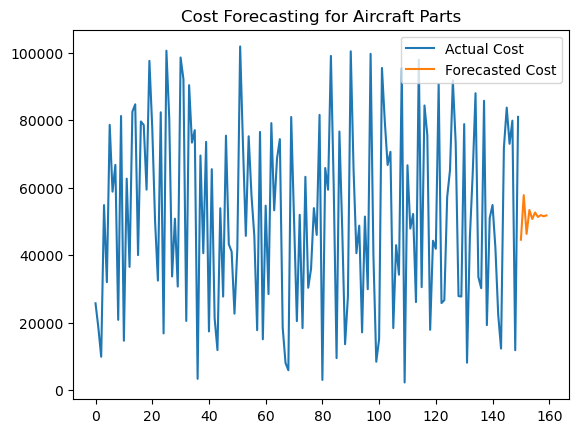

In [13]:
import pmdarima as pm
import matplotlib.pyplot as plt

cost_data = df_supply_chain['Cost per Part (USD)']

model = pm.auto_arima(cost_data, seasonal=False, stepwise=True)

n_periods = 10
forecast = model.predict(n_periods=n_periods)

plt.plot(cost_data, label='Actual Cost')
plt.plot(range(len(cost_data), len(cost_data) + n_periods), forecast, label='Forecasted Cost')
plt.legend()
plt.title('Cost Forecasting for Aircraft Parts')
plt.show()

In [14]:
def update_real_time_data(df):

    df['Quantity in Stock'] = df['Quantity in Stock'].apply(lambda x: max(0, x - random.randint(0, 2)))

    df['Time to Deliver (Days)'] = df['Time to Deliver (Days)'].apply(lambda x: max(1, x + random.randint(-2, 3)))

    df['Cost per Part (USD)'] = df['Cost per Part (USD)'].apply(lambda x: max(500, x + random.randint(-500, 1000)))

    return df

for _ in range(5):  
    df_supply_chain = update_real_time_data(df_supply_chain)

    df_supply_chain.to_csv('aircraft_supply_chain_data_real_time.csv', index=False)

    time.sleep(5)

    print(df_supply_chain.head())

  Part Number    Part Description                 Supplier        Country  \
0  0002-AC108    Engine 1 Turbine          Lockheed Martin  United States   
1      ER-222  Landing Gear Front              BAE Systems  United States   
2     BZ-9876       Fuel Injector  Leonardo (Finmeccanica)  United States   
3     AC-5678      Wing Flap Left                   Airbus  United States   
4     DL-2309   Navigation System          Lockheed Martin  United States   

   Quantity in Stock  Cost per Part (USD)  Time to Deliver (Hours)  \
0                  8                25261                       35   
1                 44                18559                        6   
2                  0                10417                        3   
3                 38                55798                       24   
4                  1                32674                       33   

  Calibration Status   Aircraft Type             Airline Aircraft Number  \
0          Unchecked      Boeing 737    

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [16]:
df_supply_chain['Calibration Status'] = df_supply_chain['Calibration Status'].apply(lambda x: 1 if x == 'Calibrated' else 0)
df_supply_chain['Supplier Country'] = df_supply_chain['Supplier'].map({
    'RTX Corporation': 'United States',
    'Airbus': 'Germany',
    'Lockheed Martin': 'United States',
    'Boeing': 'United States',
    'Northrop Grumman': 'United States',
    'Rostec': 'Russia',
    'BAE Systems': 'United Kingdom',
    'GE Aerospace': 'United States',
    'Safran': 'France',
    'Rolls-Royce Holdings': 'United Kingdom',
    'L3Harris': 'United States',
    'Leonardo': 'Italy',
    'Raytheon Company': 'United States'
})

X = df_supply_chain[['Cost per Part (USD)', 'Quantity in Stock', 'Calibration Status']]
y = df_supply_chain['Time to Deliver (Days)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

df_supply_chain['Predicted Delivery Time (Days)'] = model.predict(X)

Root Mean Squared Error (RMSE): 3.76782769025764


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

df_parts = pd.read_csv('aircraft_parts_data_with_airlines_updated.csv')
X = df_parts[['Usage Hours', 'Current Condition', 'Risk of Failure']]
y = df_parts['Predicted Damage']  

categorical_features = ['Current Condition']  
numeric_features = ['Usage Hours', 'Risk of Failure']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  
        ('cat', OneHotEncoder(), categorical_features)  
    ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline.fit(X_train, y_train)

y_pred_fail = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_fail)
print(f"Prediction Accuracy: {accuracy}")

df_parts['Predicted Failure'] = model_pipeline.predict(X)

Prediction Accuracy: 1.0


In [19]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

df_supply_chain = pd.read_csv('aircraft_supply_chain_data_real_time.csv')
df_supply_chain['Time to Deliver (Days)'] = df_supply_chain['Time to Deliver (Hours)'] / 24

df_parts = pd.read_csv('aircraft_parts_data_with_airlines_updated.csv')

fig_delivery = px.scatter(
    df_supply_chain, 
    x='Cost per Part (USD)', 
    y='Time to Deliver (Days)',  
    size='Quantity in Stock', 
    color='Supplier', 
    hover_name='Part Number',
    title='Delivery Time vs Cost per Part (USD)'
)

app.layout = html.Div([
    html.H1("Aircraft Spare Parts Supply Chain Dashboard - Real-Time"),

    dcc.Dropdown(
        id='airline-dropdown',
        options=[{'label': airline, 'value': airline} for airline in df_parts['Airline'].unique()],
        value=df_parts['Airline'].iloc[0]
    ),


    dcc.Graph(id='stock-availability-graph'),

    dcc.Graph(id='supplier-efficiency-graph'),

    dcc.Graph(id='part-failure-graph'),

    dcc.Interval(
        id='interval-component',
        interval=5*1000,  
        n_intervals=0
    )
])

@app.callback(
    Output('stock-availability-graph', 'figure'),
    [Input('airline-dropdown', 'value'), Input('interval-component', 'n_intervals')]
)
def update_stock_graph(airline, n):
    airline_data = df_supply_chain[df_supply_chain['Airline'] == airline]

    fig_stock = px.bar(airline_data, x='Part Number', y='Quantity in Stock', color='Supplier',
                       title=f'Real-Time Spare Part Stock Availability for {airline}')
    
    return fig_stock

@app.callback(
    Output('supplier-efficiency-graph', 'figure'),
    [Input('airline-dropdown', 'value'), Input('interval-component', 'n_intervals')]
)
def update_efficiency_graph(airline, n):
    airline_data = df_supply_chain[df_supply_chain['Airline'] == airline]

    fig_efficiency = px.scatter(airline_data, x='Supplier', y='Predicted Delivery Time (Days)', color='Cost per Part (USD)',
                                size='Quantity in Stock', title=f'Supplier Efficiency Prediction for {airline}')
    
    return fig_efficiency

@app.callback(
    Output('part-failure-graph', 'figure'),
    [Input('airline-dropdown', 'value'), Input('interval-component', 'n_intervals')]
)
def update_failure_graph(airline, n):
    airline_parts = df_parts[df_parts['Airline'] == airline]
    
    fig_failures = px.pie(
        airline_parts,
        names='Part Name',  
        values='Risk of Failure',  
        title=f'Predicted Part Failures for {airline}'
    )
    
    return fig_failures

if __name__ == '__main__':
    app.run_server(debug=True, port=8060)